In [2]:
import sys
sys.path.append("../script/")

import Functions
from Engine import Engine
from GTGP import GTGP


from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import numpy as np
import pandas as pd
from time import time

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# data

In [16]:
X_train = pd.read_csv("../data/madelon_train.data",delimiter=" ",header=None).iloc[:,:-1].values
y_train = pd.read_csv("../data/madelon_train.labels",delimiter=" ",header=None).values.flatten()
y_train[y_train==-1] = 0

X_test = pd.read_csv("../data/madelon_valid.data",delimiter=" ",header=None).iloc[:,:-1].values
y_test = pd.read_csv("../data/madelon_valid.labels",delimiter=" ",header=None).values.flatten()
y_test[y_test==-1] = 0

seeds = [10086, 200,500,30506,30405,30420,10056,7059,40965,5398,869543,83491,823190,
         48392,2810,48392,3498210,483902,859032,12890,538920,86954,54309,6504,9840,
         219805,548,2981,432890,5438908,219094,5843902,60854,979,12890,2108,4093]

dataset = 'madelon_chi_square_selection'

# X_train, X_test_addition, y_train, y_test_addition = train_test_split(X_train, y_train, train_size=1000,stratify=y_train)
# X_train, X_test_addition, y_train, y_test_addition = train_test_split(X_train, y_train, train_size=20,stratify=y_train)

# X_test = np.concatenate([X_test,X_test_addition])
# y_test = np.concatenate([y_test,y_test_addition])
# y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

In [5]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

# model

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

skb = SelectKBest(chi2,k=20)

In [7]:
skb.fit(X_train,y_train)

SelectKBest(k=20, score_func=<function chi2 at 0x000002762EF63740>)

# FEATURE count

In [8]:
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, heights, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = -20
    # Iterate over angles, values, and labels, to add all of them.
    for angle,height, value, label, in zip(angles, heights,values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)
        
        # And finally add the text
        ax.text(
            x=angle, 
            y=padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            fontweight="bold",
            rotation=rotation, 
            rotation_mode="anchor"
        ) 

        value = np.round(value,3).astype('str') + '%'
        ax.text(
            x=angle,
            y=height/2 - padding, 
            s=value, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 

def plot_feature_circos(features,values,title):
    num_features = len(features)

    groups_size = [1 for i in range(num_features)]
    values = np.round(values,3)
    values *= 100

    heights = values.copy().astype('float')
    rulers_heights = [0.001,0.01,0.1,1] * 100

    label = ["probability"] * num_features

    PAD = 3
    ANGLES_N = len(heights) + PAD * num_features
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)
    OFFSET = np.pi / 2

    # Obtaining the right indexes is now a little more complicated
    offset = 0
    IDXS = []
    for size in groups_size:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD
        
    # Same layout as above
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})

    ax.set_theta_offset(OFFSET)
    ax.set_ylim(-100, 100)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    cmap = plt.cm.get_cmap('viridis', num_features)
    COLORS = [cmap(i) for i in range(num_features)]
    # And finally add the bars. 
    # Note again the `ANGLES[IDXS]` to drop some angles that leave the space between bars.
    ax.bar(
        ANGLES[IDXS], heights, width=WIDTH, color=COLORS, 
        edgecolor="white", linewidth=2
    )

    add_labels(ANGLES[IDXS], heights,values, features, OFFSET, ax)

    offset = 0 
    for group, size in zip(features, groups_size):
        rotation, alignment = get_label_rotation(ANGLES[offset + size//2 + PAD - 1], OFFSET)

        # Add line below bars
        curve = 100
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=curve)
        ax.plot(x1, [-10] * curve, color="#333333")

        rotation, alignment = get_label_rotation(ANGLES[offset + size//2 + PAD//2 - 1] , OFFSET)
        rotation += 90 if alignment == 'right' else -90
        
        # Add reference lines
        x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
        for ruler_height,ruler in zip(rulers_heights,['10','100','1,000','10,000']):
            ax.plot(x2, [ruler_height] * 50, color="#bebebe", lw=0.8)
        offset += size + PAD

    plt.title(title)
    plt.show()

def find_terminals(node):
    if node.terminal == True:
        return [node.index]
    else:
        ts = []
        for n in node.sons:
            ts.extend(find_terminals(n))
        return ts

feature_index = np.argsort(skb.scores_)[::-1][:20]
feature_score = skb.scores_[feature_index]
feature_score = feature_score/feature_score.sum()

C:\Users\zhouz\AppData\Local\Temp\ipykernel_126048\3652658212.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_features)


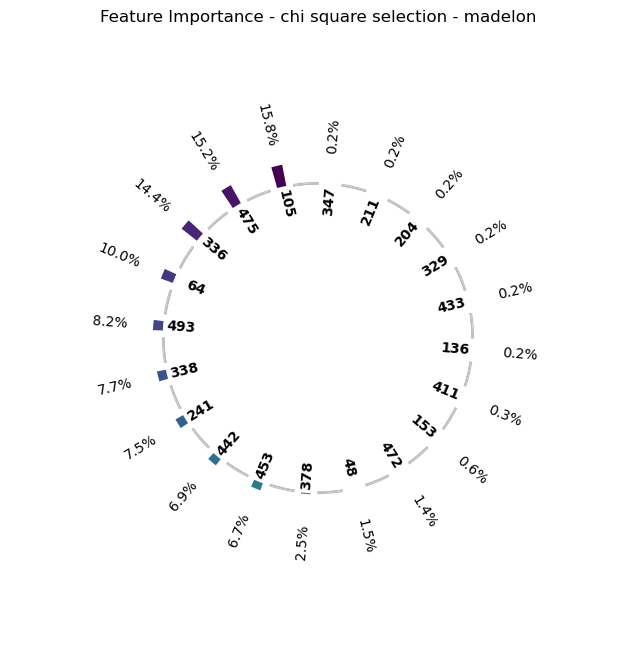

In [73]:
plot_feature_circos(features=feature_index,
                        values  = feature_score,
                        title = "Feature Importance - chi square selection - madelon"
                        )

# select feature

In [26]:
X_train = X_train[:,feature_index]
X_test = X_test[:,feature_index]

# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
for i in range(30):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
    y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
    clf = DecisionTreeClassifier()
    clf.fit(X_train,y_train)

    num_trees = 1
    depth = clf.tree_.max_depth
    num_nodes = clf.tree_.node_count

    train_acc = accuracy_score(y_train,clf.predict(X_train))
    test_acc = accuracy_score(y_test,clf.predict(X_test))
    train_roc = roc_auc_score(y_train_one_hot.toarray(),clf.predict_proba(X_train))
    test_roc = roc_auc_score(y_test_one_hot.toarray(),clf.predict_proba(X_test))

    with open('./benchmark_DC/'+dataset+'.csv','a') as f:
        s = str(train_acc)+","+str(test_acc)+","+str(train_roc)+","+str(test_roc)+","+str(num_trees)+","+str(depth)+","+str(num_nodes)+"\n"
        f.writelines(s)

# XGBoost

In [31]:
import xgboost


In [32]:
for i in range(30):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
    
    y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
    # xgb = xgboost.XGBClassifier(min_child_weight=0,max_depth=3,n_estimators=100)
    # xgb = xgboost.XGBClassifier(min_child_weight=0,max_depth=4)
    xgb = xgboost.XGBClassifier()
    xgb.fit(X_train,y_train)

    import json

    def item_generator(json_input, lookup_key):
        if isinstance(json_input, dict):
            for k, v in json_input.items():
                if k == lookup_key:
                    yield v
                else:
                    yield from item_generator(v, lookup_key)
        elif isinstance(json_input, list):
            for item in json_input:
                yield from item_generator(item, lookup_key)

    def tree_depth(json_text):
        json_input = json.loads(json_text)
        depths = list(item_generator(json_input, 'depth'))
        return max(depths) + 1 if len(depths) != 0 else 1

    train_acc = accuracy_score(y_train,xgb.predict(X_train))
    test_acc = accuracy_score(y_test,xgb.predict(X_test))
    train_roc = roc_auc_score(y_train_one_hot.toarray(),xgb.predict_proba(X_train))
    test_roc = roc_auc_score(y_test_one_hot.toarray(),xgb.predict_proba(X_test))

    booster = xgb.get_booster()

    tree_df = booster.trees_to_dataframe()
    depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
    num_trees = len(depths)
    depth = np.average(depths)
    num_nodes = len(tree_df)

    with open('./benchmark_xgb/'+dataset+'.csv','a') as f:
        s = str(train_acc)+","+str(test_acc)+","+str(train_roc)+","+str(test_roc)+","+str(num_trees)+","+str(depth)+","+str(num_nodes)+"\n"
        f.writelines(s)

# GDBT

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

In [34]:
for i in range(30):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
    y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
    clf = GradientBoostingClassifier()
    # clf = GradientBoostingClassifier()
    clf.fit(X_train,y_train)

    train_acc = accuracy_score(y_train,clf.predict(X_train))
    test_acc = accuracy_score(y_test,clf.predict(X_test))
    train_roc = roc_auc_score(y_train_one_hot.toarray(),clf.predict_proba(X_train))
    test_roc = roc_auc_score(y_test_one_hot.toarray(),clf.predict_proba(X_test))

    num_trees = len([ est for ests in clf.estimators_ for est in ests])
    depth = np.average([ max(1,est.tree_.max_depth) for ests in clf.estimators_ for est in ests])
    num_nodes = sum([ est.tree_.node_count for ests in clf.estimators_ for est in ests])

    with open('./benchmark_GBDT/'+dataset+'.csv','a') as f:
        s = str(train_acc)+","+str(test_acc)+","+str(train_roc)+","+str(test_roc)+","+str(num_trees)+","+str(depth)+","+str(num_nodes)+"\n"
        f.writelines(s)

# Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
for i in range(30):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,stratify=y, random_state=seeds[i])
    y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)
    rfc = RandomForestClassifier()
    rfc.fit(X_train,y_train)

    train_acc = accuracy_score(y_train,rfc.predict(X_train))
    test_acc = accuracy_score(y_test,rfc.predict(X_test))
    train_roc = roc_auc_score(y_train_one_hot.toarray(),rfc.predict_proba(X_train))
    test_roc = roc_auc_score(y_test_one_hot.toarray(),rfc.predict_proba(X_test))

    num_trees = len(rfc.estimators_)
    depth = np.average([est.tree_.max_depth for est in rfc.estimators_])
    num_nodes = sum([est.tree_.node_count for est in rfc.estimators_])

    with open('./benchmark_RF/'+dataset+'.csv','a') as f:
        s = str(train_acc)+","+str(test_acc)+","+str(train_roc)+","+str(test_roc)+","+str(num_trees)+","+str(depth)+","+str(num_nodes)+"\n"
        f.writelines(s)